In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

# ตั้งค่า Theme และฟอนต์สำหรับกราฟ
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Tahoma' # หรือฟอนต์ภาษาไทยอื่น ๆ เช่น 'Sarabun'
plt.rcParams['figure.figsize'] = (12, 6)

In [10]:
# อ่านไฟล์ข้อมูลทั้งหมด
df_gold = pd.read_csv('gold_history_updated.csv')
df_btc = pd.read_csv('bitcoin_history_updated.csv')
df_fx = pd.read_csv('exchange_rate_updated.csv')
df_oil = pd.read_csv('petroleum_data_updated.csv')
df_cpi = pd.read_csv('CPI_clean_updated.csv')
df_set = pd.read_csv('set_index_updated.csv')

In [11]:
# 1. จัดการข้อมูลราคาทองคำ (Gold)
# ตรวจสอบรูปแบบวันที่และแปลง
if 'datetime' in df_gold.columns:
    df_gold['date'] = pd.to_datetime(df_gold['datetime'], errors='coerce')
else:
    df_gold['date'] = pd.to_datetime(df_gold['date'], dayfirst=True, errors='coerce')

col_gold = 'gold_bar_sell' if 'gold_bar_sell' in df_gold.columns else 'gold_sell'
df_gold = df_gold[['date', col_gold]].rename(columns={col_gold: 'gold'})

# 2. จัดการข้อมูล Bitcoin (BTC)
df_btc['date'] = pd.to_datetime(df_btc['date'])

# 3. จัดการข้อมูลอัตราแลกเปลี่ยน (FX)
df_fx['date'] = pd.to_datetime(df_fx['date'])
df_fx = df_fx[['date', 'mid_rate']].rename(columns={'mid_rate': 'fx'})

# 4. จัดการข้อมูลราคาน้ำมัน (Oil)
# เลือกเฉพาะ 'U.S. Diesel' เพื่อเป็นตัวแทนราคาน้ำมันโลก และสร้างวันที่จากเดือน/ปี
df_oil['date'] = pd.to_datetime(df_oil['period'].astype(str) + '-01', errors='coerce')
df_oil = df_oil[df_oil['product-name'].str.contains('No 2 Diesel', na=False) & (df_oil['area-name'] == 'U.S.')]
df_oil = df_oil[['date', 'value']].rename(columns={'value': 'oil'})

# 5. จัดการข้อมูลเงินเฟ้อ (CPI)
# เลือกเฉพาะ code 0 (ดัชนีรวม)
df_cpi = df_cpi[df_cpi['code'] == 0].copy()
df_cpi['date'] = pd.to_datetime(df_cpi['date'])
df_cpi = df_cpi[['date', 'cpi_index']].rename(columns={'cpi_index': 'cpi'})

# 6. จัดการข้อมูลตลาดหุ้น (SET Index)
# แปลงข้อมูลตัวเลขที่อาจเป็น String ให้เป็น Numeric
df_set = df_set[pd.to_numeric(df_set['Close'], errors='coerce').notnull()]
df_set['date'] = pd.to_datetime(df_set['date'])
df_set['Close'] = pd.to_numeric(df_set['Close'])
df_set = df_set[['date', 'Close']].rename(columns={'Close': 'set'})

In [12]:
# สร้างช่วงวันที่ทั้งหมดเพื่อให้ครอบคลุมข้อมูล
all_dates = sorted(list(set(df_gold['date'].dropna()) | set(df_btc['date'].dropna())))
date_range = pd.DataFrame({'date': pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')})

# เตรียมข้อมูล FX รายวัน (เติมค่าที่ขาดด้วยการ Interpolate)
fx_daily = pd.merge(date_range, df_fx, on='date', how='left')
fx_daily['fx'] = fx_daily['fx'].interpolate(method='linear').ffill().bfill()

# รวม Bitcoin เข้ากับ FX
df_btc_merge = pd.merge(df_btc, fx_daily, on='date', how='left')

# Logic: ถ้าราคาต่ำกว่า 500,000 บาท สันนิษฐานว่าเป็น USD -> คูณด้วย FX
mask_usd = df_btc_merge['btc_price'] < 500000
df_btc_merge.loc[mask_usd, 'btc_price'] = df_btc_merge.loc[mask_usd, 'btc_price'] * df_btc_merge.loc[mask_usd, 'fx']

# ได้ DataFrame ของ BTC ที่เป็นบาทเรียบร้อย
df_btc_clean = df_btc_merge[['date', 'btc_price']].rename(columns={'btc_price': 'btc'})

In [13]:
# รายการ DataFrame ที่จะรวม
dfs = [df_gold, df_btc_clean, df_fx, df_oil, df_cpi, df_set]

# รวมตารางทั้งหมดด้วย 'date' (Outer Join เพื่อเก็บข้อมูลทุกวันไว้ก่อน)
df_final = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), dfs)

# เรียงวันที่
df_final = df_final.sort_values('date')

# เติมข้อมูลที่ขาดหายไป (Forward Fill) สำหรับข้อมูลรายเดือน (CPI, Oil) ให้มีค่าทุกวัน
df_final = df_final.ffill()

# ตัดข้อมูลเฉพาะปี 2023 เป็นต้นไป (ช่วงที่มีข้อมูลครบทุกตัวแปร)
df_final = df_final[df_final['date'] >= '2023-01-01']

# ลบแถวที่ยังมีค่าว่าง (หากข้อมูลต้นทางขาดหายไปจริงๆ)
df = df_final.dropna()

# ดูตัวอย่างข้อมูล
print(df.head())

        date     gold            btc       fx    oil     cpi          set
3 2023-01-03  30450.0  555097.347064  33.2294  4.576  100.37  1678.969971
4 2023-01-04  30450.0  561622.538146  33.2294  4.576  100.37  1673.250000
5 2023-01-05  30250.0  561161.700880  33.2294  4.576  100.37  1663.859985
6 2023-01-06  30150.0  565426.889451  33.2294  4.576  100.37  1673.859985
7 2023-01-07  30250.0  565955.319795  33.2294  4.576  100.37  1673.859985


✅ Saved chart: eda_07_corr_gold_vs_ecofactor.png


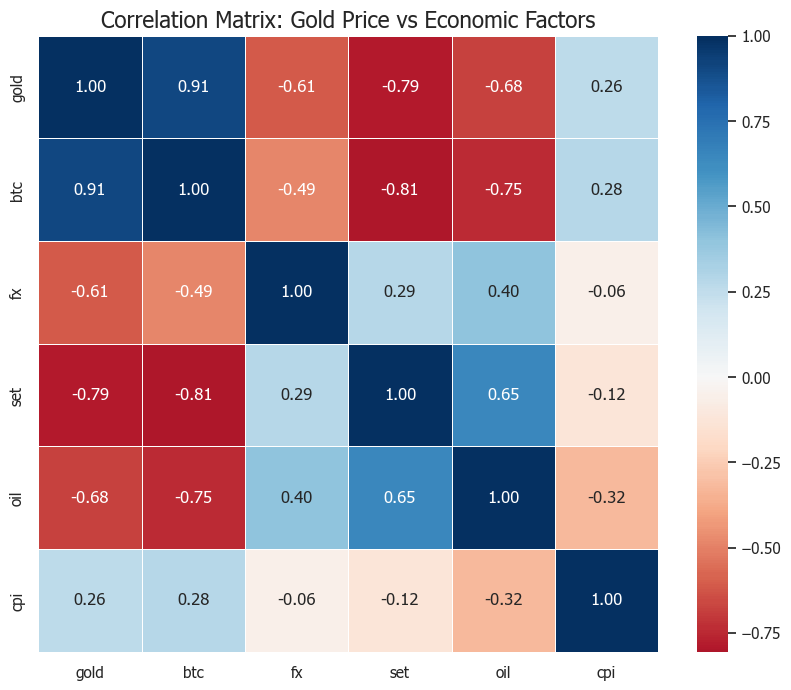

In [16]:
plt.figure(figsize=(10, 8))

# คำนวณ Correlation
corr_matrix = df[['gold', 'btc', 'fx', 'set', 'oil', 'cpi']].corr()

# วาด Heatmap
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix: Gold Price vs Economic Factors', fontsize=16)
filename = f"eda_07_corr_gold_vs_ecofactor.png"  
plt.savefig(filename, dpi=300)    
print(f"✅ Saved chart: {filename}")
plt.show()

✅ Saved chart: eda_07_gold_vs_set.png


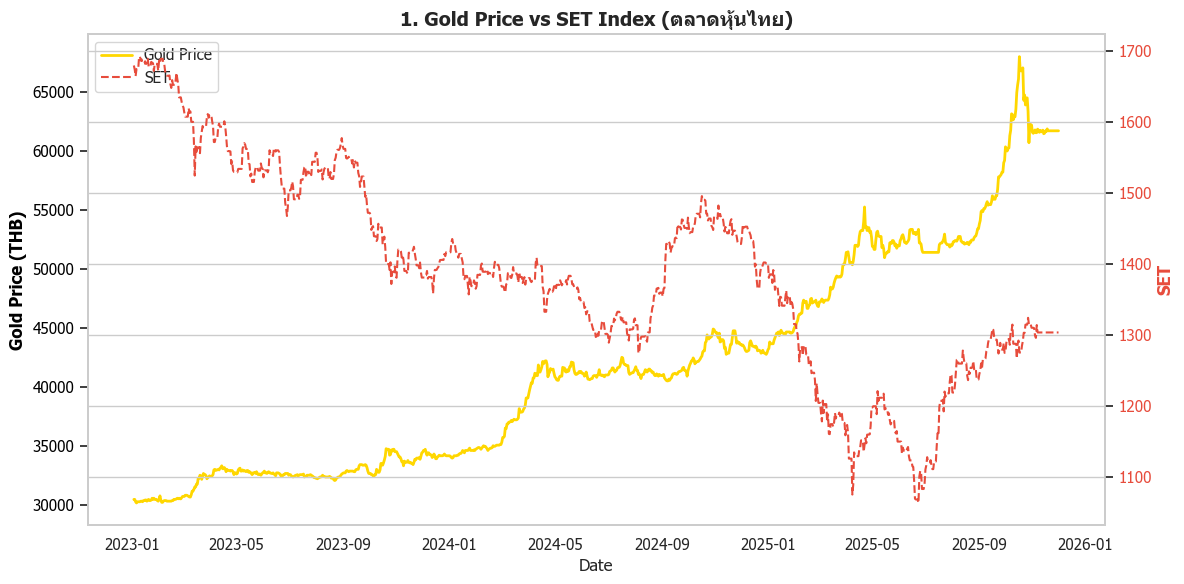

✅ Saved chart: eda_07_gold_vs_oil.png


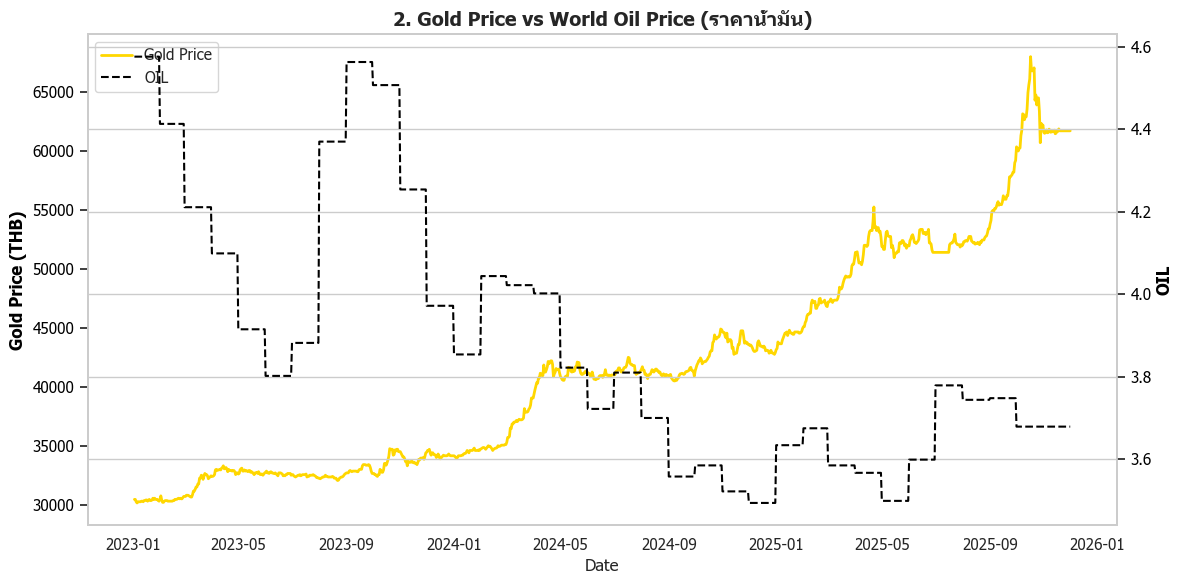

✅ Saved chart: eda_07_gold_vs_fx.png


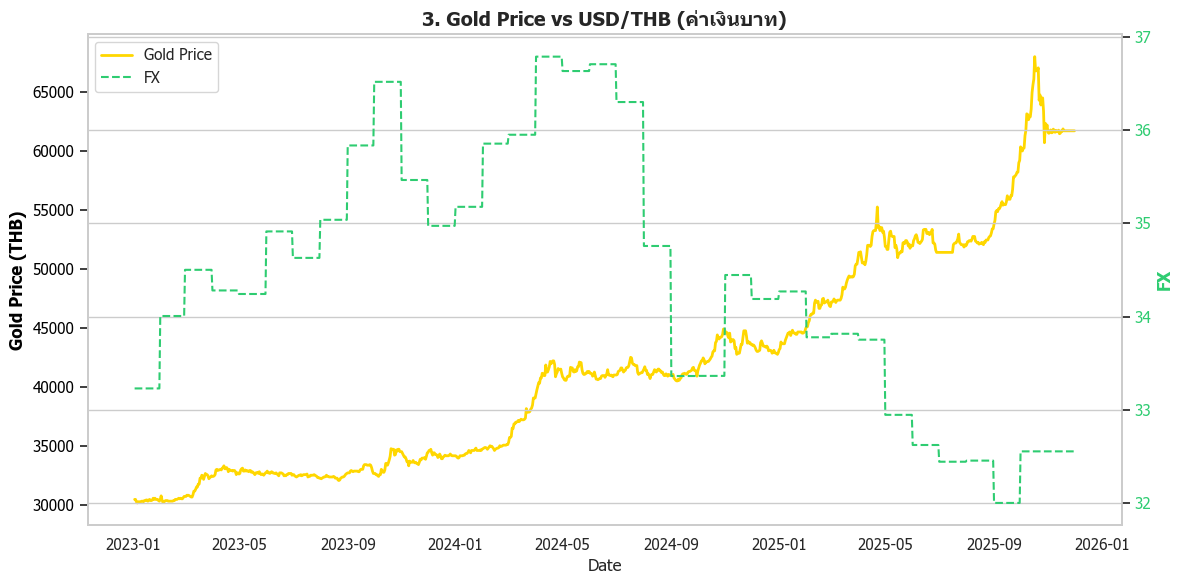

✅ Saved chart: eda_07_gold_vs_btc.png


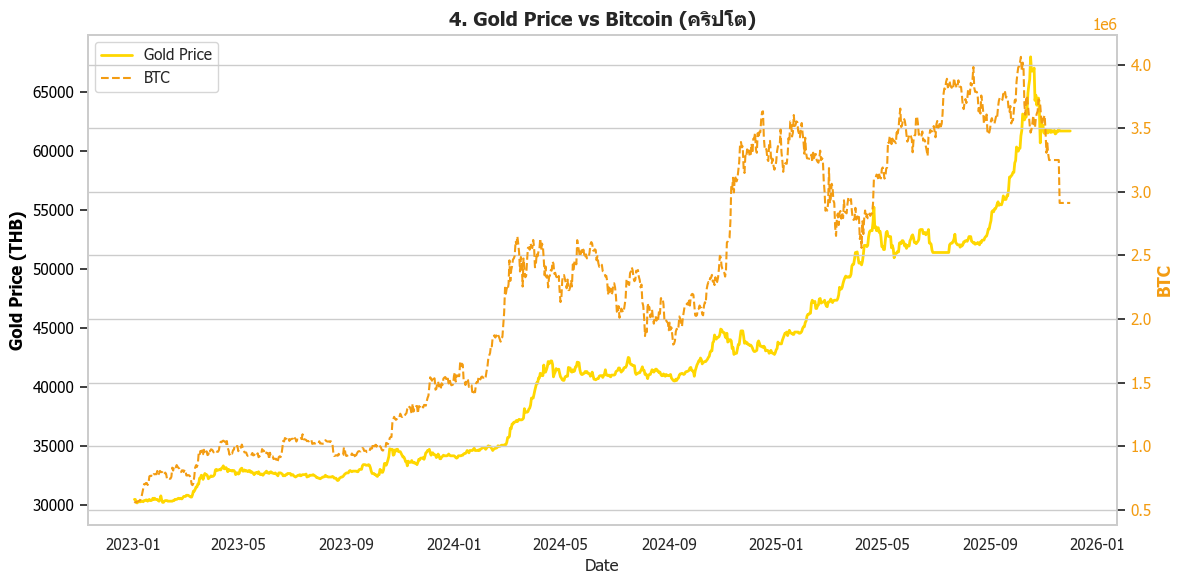

✅ Saved chart: eda_07_gold_vs_cpi.png


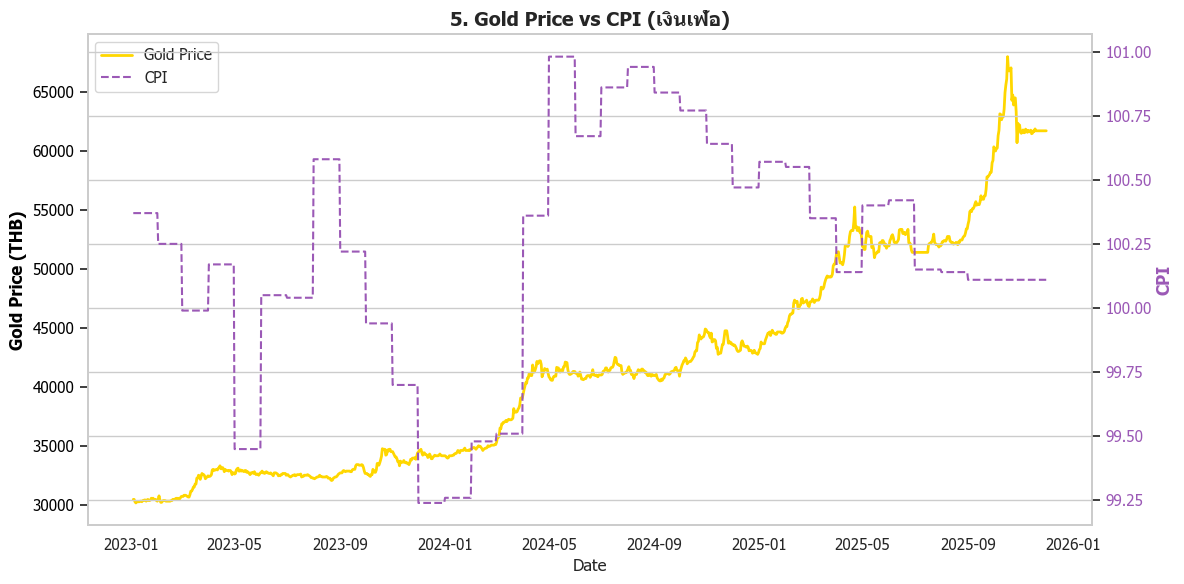

In [17]:
def plot_dual_axis(data, col1, col2, title, color2):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # แกนซ้าย (Primary): ราคาทองคำ
    color1 = '#FFD700'  # สีทอง
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Gold Price (THB)', color='black', fontweight='bold')
    ax1.plot(data['date'], data[col1], color=color1, label='Gold Price', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(False) # ปิด Grid แกนซ้ายเพื่อความสะอาดตา

    # แกนขวา (Secondary): ตัวแปรคู่เทียบ
    ax2 = ax1.twinx()
    ax2.set_ylabel(col2.upper(), color=color2, fontweight='bold')
    ax2.plot(data['date'], data[col2], color=color2, label=col2.upper(), linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # รวม Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    # --- ส่วนที่เพิ่มเข้ามา: บันทึกรูปภาพเป็น PNG ---
    filename = f"eda_07_gold_vs_{col2}.png"  # สร้างชื่อไฟล์อัตโนมัติ เช่น gold_vs_set.png
    plt.savefig(filename, dpi=300)    # บันทึกไฟล์ (dpi=300 เพื่อความคมชัด)
    print(f"✅ Saved chart: {filename}")
    
    plt.show()

# รายการกราฟที่ต้องการพล็อต
charts = [
    ('set', '1. Gold Price vs SET Index (ตลาดหุ้นไทย)', '#E74C3C'),   
    ('oil', '2. Gold Price vs World Oil Price (ราคาน้ำมัน)', 'black'), 
    ('fx',  '3. Gold Price vs USD/THB (ค่าเงินบาท)', '#2ECC71'),       
    ('btc', '4. Gold Price vs Bitcoin (คริปโต)', '#F39C12'),           
    ('cpi', '5. Gold Price vs CPI (เงินเฟ้อ)', '#9B59B6')              
]

# วนลูปสร้างกราฟ
for col, title, color in charts:
    plot_dual_axis(df, 'gold', col, title, color)

📌 Variables to process: ['gold', 'fx', 'cpi', 'oil', 'set', 'btc']
✅ Data prepared for model analysis.
   Original shape: (1086, 32)
   Model-ready shape: (1079, 32)
   Number of features: 30

🔍 Top 10 Features correlated with Next Day Gold Price:
gold_next          1.000000
gold               0.999506
gold_lag1          0.999021
gold_roll7_mean    0.998407
gold_lag3          0.997900
btc_roll7_mean     0.911500
btc_lag3           0.910039
btc_lag1           0.908439
btc                0.907216
cpi_roll7_mean     0.265650
cpi                0.264504
Name: gold_next, dtype: float64


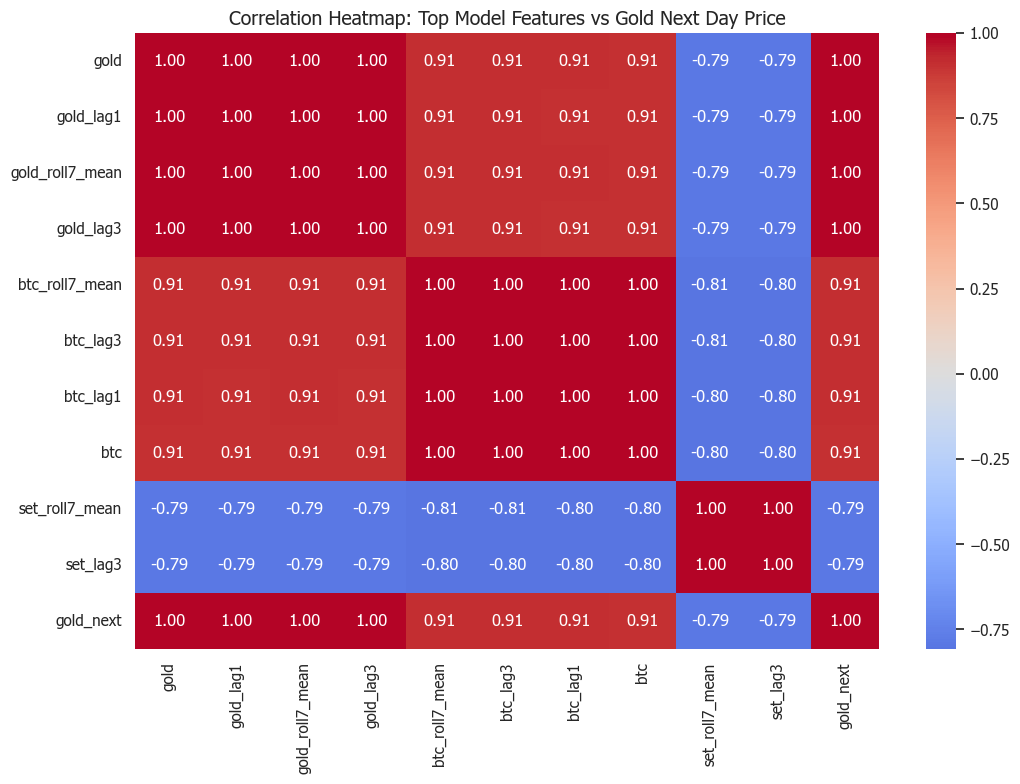

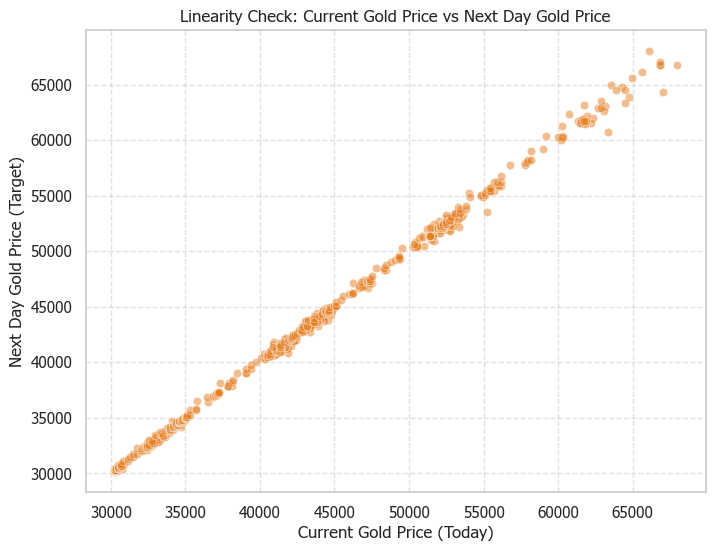

In [20]:
# --- Cell: Advanced Feature Engineering & Analysis for Model Preparation ---

# [FIX] สร้าง Copy ของข้อมูลเพื่อป้องกัน SettingWithCopyWarning
df = df.copy()

# 1. กำหนดตัวแปรตามที่โมเดลใช้
base_vars = ["gold", "fx", "cpi", "oil", "set"]
# ตรวจสอบว่ามี btc หรือไม่ ถ้ามีให้เพิ่มเข้าไป
if 'btc' in df.columns:
    base_vars.append("btc")

print(f"📌 Variables to process: {base_vars}")

# 2. สร้าง Target Variable (gold_next)
# โมเดลต้องการทำนายราคาทอง 'วันถัดไป' ดังนั้นเราต้อง shift ข้อมูลขึ้น 1 วัน
df['gold_next'] = df['gold'].shift(-1)

# 3. สร้าง Features (Lags, Rolling, Pct Change) ตาม train_model.py
feature_cols = []
for var in base_vars:
    # Lag features (อดีต 1 วัน และ 3 วัน)
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag3'] = df[var].shift(3)
    
    # Rolling mean (ค่าเฉลี่ยย้อนหลัง 7 วัน)
    df[f'{var}_roll7_mean'] = df[var].rolling(window=7).mean()
    
    # Percent change (การเปลี่ยนแปลงเป็นเปอร์เซ็นต์เทียบกับวันก่อนหน้า)
    df[f'{var}_pct_change'] = df[var].pct_change()
    
    # เก็บชื่อคอลัมน์ฟีเจอร์ไว้สำหรับวิเคราะห์
    feature_cols.extend([
        f"{var}_lag1", 
        f"{var}_lag3", 
        f"{var}_roll7_mean", 
        f"{var}_pct_change"
    ])

# เพิ่มตัวแปรต้นฉบับเข้าไปในรายการฟีเจอร์ด้วย
feature_cols.extend(base_vars)

# 4. ลบแถวที่มีค่าว่าง (NaN) ที่เกิดจากการ shift/rolling
# เพื่อให้เหลือเฉพาะข้อมูลที่พร้อมเข้าโมเดลจริง ๆ
df_model = df.dropna().copy()

print(f"✅ Data prepared for model analysis.")
print(f"   Original shape: {df.shape}")
print(f"   Model-ready shape: {df_model.shape}")
print(f"   Number of features: {len(feature_cols)}")

# --- 5. วิเคราะห์ Correlation กับ Target (gold_next) ---
# คำนวณ Correlation เฉพาะกับตัวแปรเป้าหมาย
correlations = df_model[feature_cols + ['gold_next']].corr()['gold_next'].sort_values(ascending=False)

# แสดง Top 10 Correlations
print("\n🔍 Top 10 Features correlated with Next Day Gold Price:")
print(correlations.head(11)) # 11 เพราะรวมตัวมันเอง (gold_next) ด้วย

# --- 6. Plot Correlation Heatmap (Top Features) ---
# เลือกฟีเจอร์ที่มีความสัมพันธ์สูงสุด 10 อันดับแรก มาพลอตกราฟ
top_features = correlations.abs().sort_values(ascending=False)[1:11].index.tolist()
plt.figure(figsize=(12, 8))
sns.heatmap(df_model[top_features + ['gold_next']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title("Correlation Heatmap: Top Model Features vs Gold Next Day Price", fontsize=14)
plt.show()

# --- 7. Lag Plot Analysis ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_model['gold'], y=df_model['gold_next'], alpha=0.5, color='#E67E22')
plt.title("Linearity Check: Current Gold Price vs Next Day Gold Price")
plt.xlabel("Current Gold Price (Today)")
plt.ylabel("Next Day Gold Price (Target)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [21]:
# --- Cell: Statistical Hypothesis Testing (Stationarity Check) ---
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    """
    ฟังก์ชันสำหรับทดสอบ Augmented Dickey-Fuller (ADF)
    เพื่อเช็คว่าข้อมูลมีความนิ่ง (Stationary) หรือไม่
    """
    # ลบค่าว่างก่อนทดสอบ
    series = series.dropna()
    
    print(f"------------------------------------------")
    print(f"🔬 Testing Stationarity for: {name}")
    
    result = adfuller(series)
    
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result, labels):
        print(f"  {label} : {value:.4f}")
    
    # การแปลผล
    if result[1] <= 0.05:
        print("  ✅ ผลลัพธ์: Data is Stationary (ข้อมูลนิ่งแล้ว -> พร้อมใช้กับโมเดล)")
    else:
        print("  ❌ ผลลัพธ์: Data is Non-Stationary (ข้อมูลไม่นิ่ง -> อาจต้องทำ Differencing)")

# เลือกตัวแปรที่ต้องการทดสอบ
vars_to_test = ['gold', 'fx', 'set', 'oil']
if 'btc' in df.columns:
    vars_to_test.append('btc')

print("📊 ผลการทดสอบสมมติฐาน (Hypothesis Testing - ADF Test)\n")

# วนลูปทดสอบตัวแปรต้นฉบับ (Raw Price)
print(">>> 1. ทดสอบข้อมูลราคาดิบ (Original Price)")
for col in vars_to_test:
    adf_test(df[col], col)

print("\n" + "="*50 + "\n")

# วนลูปทดสอบข้อมูลที่แปลงแล้ว (Percent Change / Returns)
# ปกติราคาดิบมักจะไม่นิ่ง แต่ % การเปลี่ยนแปลงมักจะนิ่ง
print(">>> 2. ทดสอบข้อมูลการเปลี่ยนแปลงราคา (Percent Change / Returns)")
for col in vars_to_test:
    # สร้างชื่อคอลัมน์ pct change ที่เราทำไว้ในขั้นตอน Feature Engineering
    pct_col = f"{col}_pct_change"
    
    # ถ้ายังไม่ได้สร้าง ให้สร้างใหม่ตรงนี้ชั่วคราวเพื่อทดสอบ
    if pct_col not in df.columns:
        temp_series = df[col].pct_change()
    else:
        temp_series = df[pct_col]
        
    adf_test(temp_series, pct_col)

📊 ผลการทดสอบสมมติฐาน (Hypothesis Testing - ADF Test)

>>> 1. ทดสอบข้อมูลราคาดิบ (Original Price)
------------------------------------------
🔬 Testing Stationarity for: gold
  ADF Test Statistic : 0.6836
  p-value : 0.9895
  # Lags Used : 17.0000
  # Observations : 1068.0000
  ❌ ผลลัพธ์: Data is Non-Stationary (ข้อมูลไม่นิ่ง -> อาจต้องทำ Differencing)
------------------------------------------
🔬 Testing Stationarity for: fx
  ADF Test Statistic : -1.0981
  p-value : 0.7158
  # Lags Used : 0.0000
  # Observations : 1085.0000
  ❌ ผลลัพธ์: Data is Non-Stationary (ข้อมูลไม่นิ่ง -> อาจต้องทำ Differencing)
------------------------------------------
🔬 Testing Stationarity for: set
  ADF Test Statistic : -1.9752
  p-value : 0.2975
  # Lags Used : 0.0000
  # Observations : 1085.0000
  ❌ ผลลัพธ์: Data is Non-Stationary (ข้อมูลไม่นิ่ง -> อาจต้องทำ Differencing)
------------------------------------------
🔬 Testing Stationarity for: oil
  ADF Test Statistic : -2.2217
  p-value : 0.1985
  # Lags Used

📊 Scatter Plots: Gold Price vs Economic Indicators



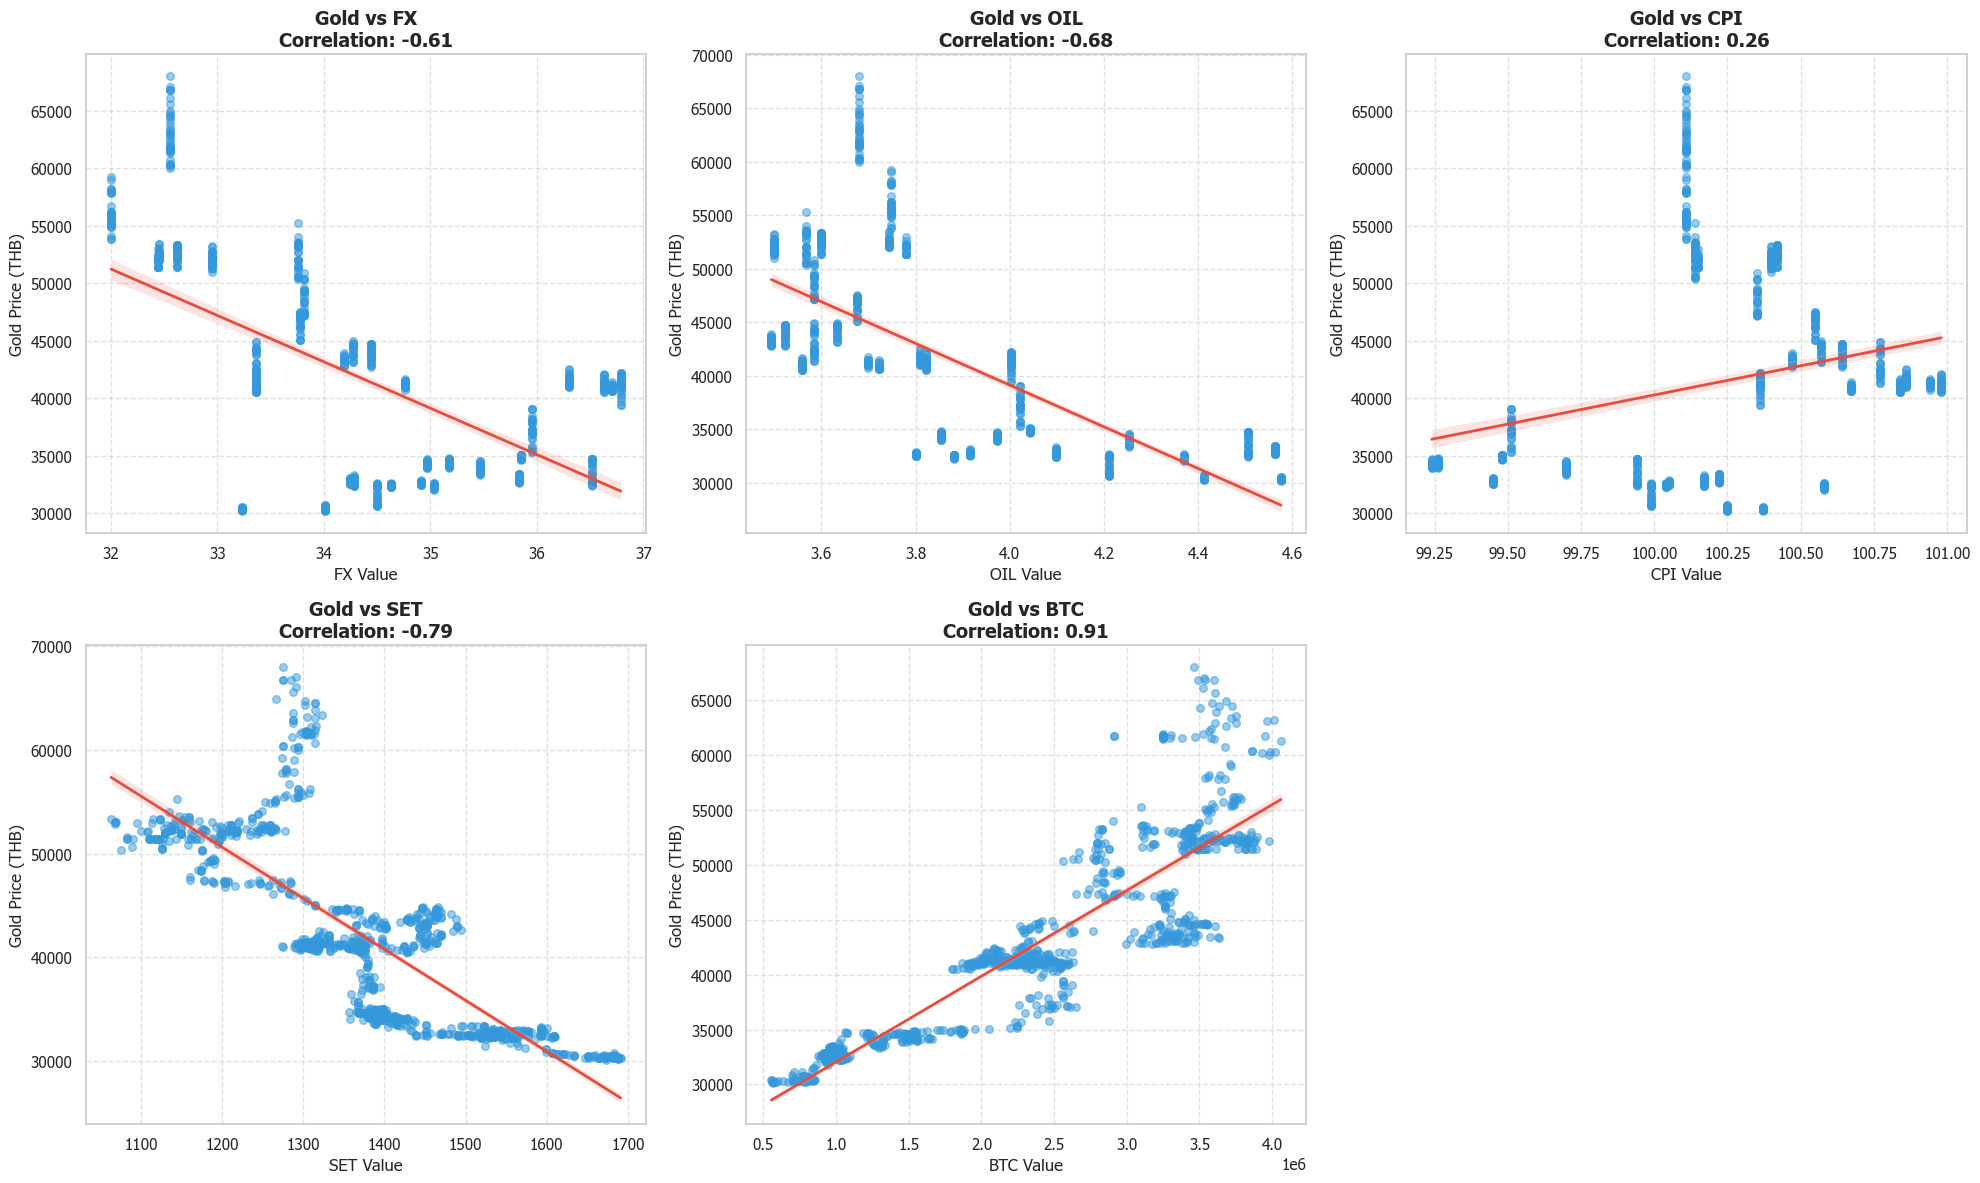

In [22]:
# --- Cell: Scatter Plot Analysis (Visualizing Relationships) ---
# กราฟนี้จะช่วยขยายความจาก Heatmap เพื่อให้เห็น "ลักษณะ" ของความสัมพันธ์ (Pattern)
# ว่าเป็นเส้นตรง (Linear), เส้นโค้ง (Curved), หรือมีการกระจายตัวแบบไหน

# 1. กำหนดตัวแปรที่ต้องการเทียบกับราคาทอง (Gold)
features_to_plot = ['fx', 'oil', 'cpi', 'set']
# เช็คว่ามี btc หรือไม่ (เผื่อข้อมูลไม่มี)
if 'btc' in df.columns:
    features_to_plot.append('btc')

# 2. ตั้งค่าหน้ากระดาษสำหรับวาดกราฟหลายรูปพร้อมกัน (Subplots)
n_cols = 3  # จำนวนกราฟแนวนอน
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols # คำนวณจำนวนแถวอัตโนมัติ

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
axes = axes.flatten() # แปลงอาเรย์ 2 มิติเป็น 1 มิติเพื่อให้วนลูปง่าย

print(f"📊 Scatter Plots: Gold Price vs Economic Indicators\n")

# 3. วนลูปสร้างกราฟทีละตัวแปร
for i, feature in enumerate(features_to_plot):
    # ใช้ sns.regplot เพื่อสร้าง Scatter Plot พร้อมเส้นแนวโน้ม (Regression Line)
    sns.regplot(x=feature, y='gold', data=df, ax=axes[i], 
                scatter_kws={'alpha': 0.5, 'color': '#3498DB', 's': 30}, # จุดสีฟ้าจางๆ
                line_kws={'color': '#E74C3C', 'linewidth': 2})           # เส้นแนวโน้มสีแดง
    
    # คำนวณค่า Correlation เพื่อใส่ในหัวข้อกราฟ
    corr_value = df['gold'].corr(df[feature])
    
    # ตกแต่งกราฟ
    axes[i].set_title(f"Gold vs {feature.upper()}\nCorrelation: {corr_value:.2f}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f"{feature.upper()} Value", fontsize=12)
    axes[i].set_ylabel("Gold Price (THB)", fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# ลบแกนกราฟที่ว่าง (ถ้ามี)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

📊 Distribution Plots (Histogram & KDE)



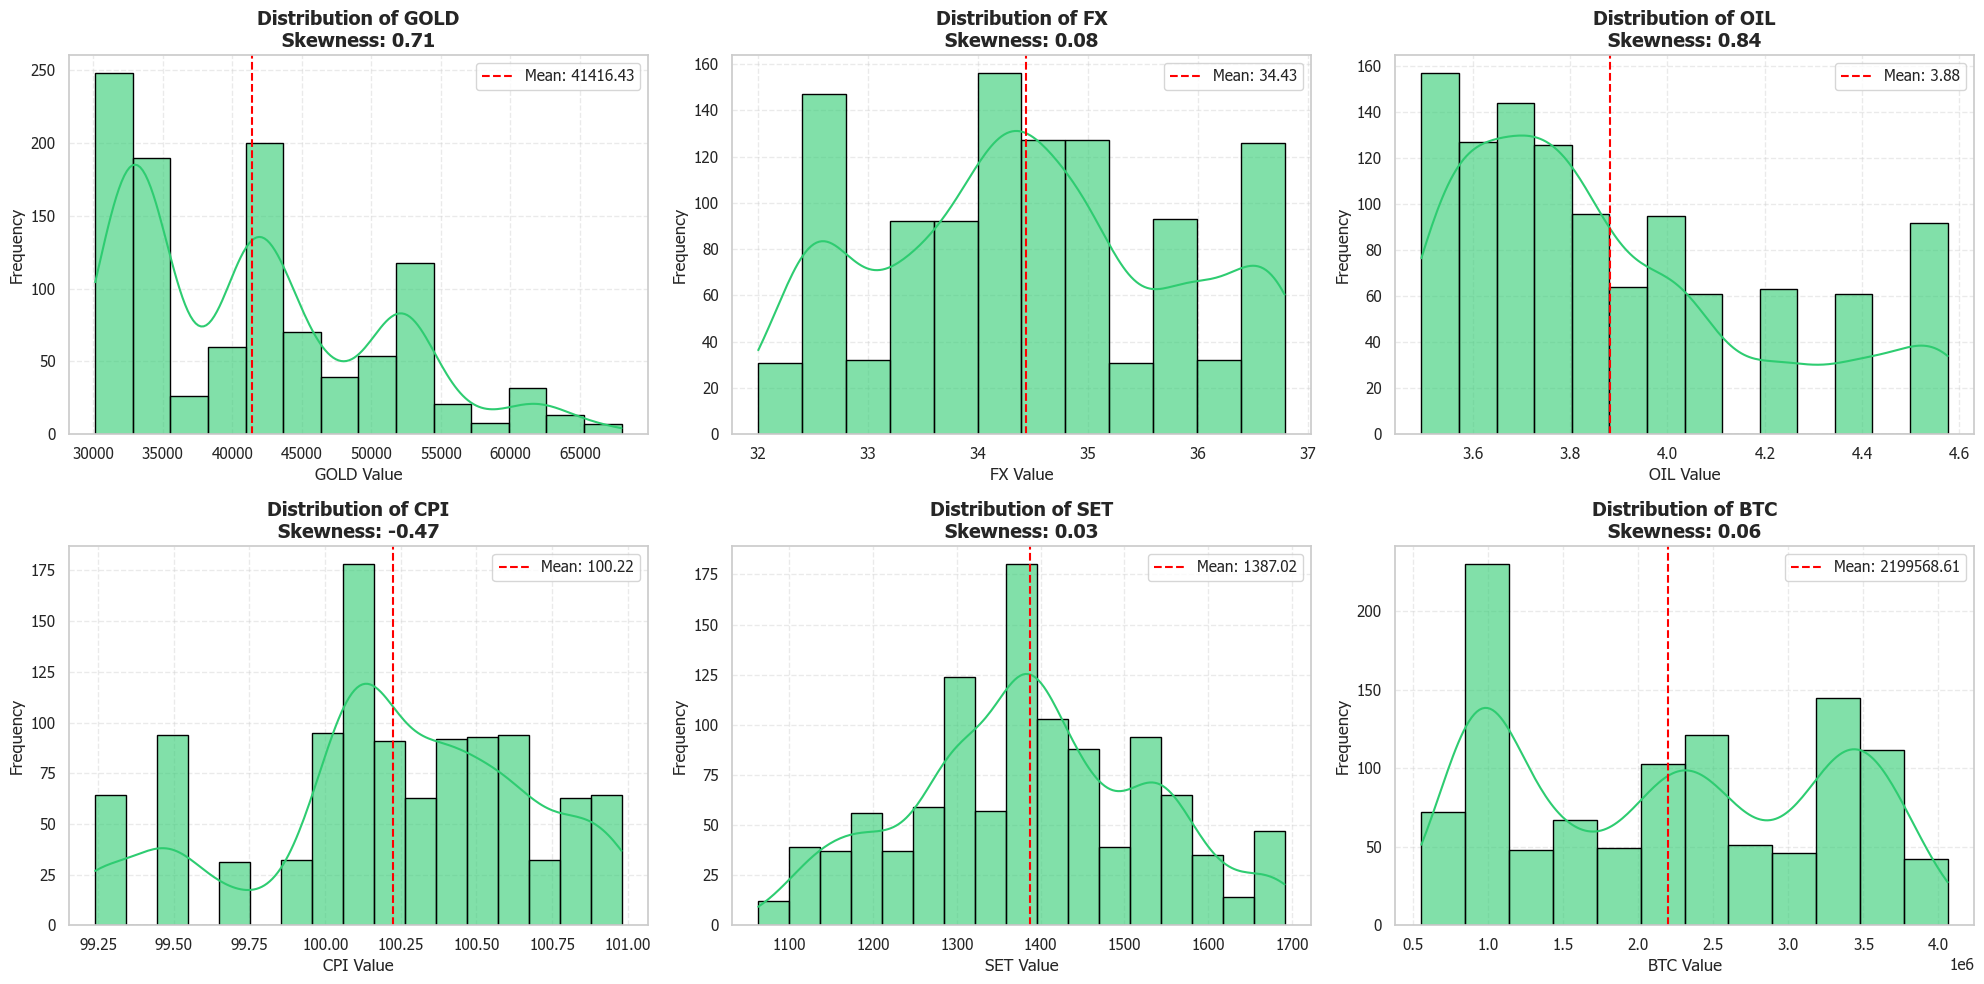

In [23]:
# --- Cell: Distribution Analysis (Histogram & KDE) ---
# กราฟนี้ช่วยตรวจสอบว่าข้อมูลมีการแจกแจงแบบไหน (Normal, Skewed, หรือมี Outlier)
# ข้อมูลการเงิน (Financial Data) มักจะไม่เป็น Normal Distribution (เบ้ซ้าย/ขวา หรือ หางหนา)

# 1. กำหนดตัวแปรที่ต้องการดูการกระจายตัว
features_to_plot = ['gold', 'fx', 'oil', 'cpi', 'set']
# ตรวจสอบว่ามี btc หรือไม่ (เผื่อข้อมูลไม่มี)
if 'btc' in df.columns:
    features_to_plot.append('btc')

# 2. ตั้งค่าหน้ากระดาษสำหรับวาดกราฟหลายรูปพร้อมกัน
n_cols = 3  # จำนวนกราฟแนวนอน
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols # คำนวณจำนวนแถวอัตโนมัติ

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten() # แปลงเป็น 1 มิติเพื่อให้วนลูปง่าย

print(f"📊 Distribution Plots (Histogram & KDE)\n")

# 3. วนลูปสร้างกราฟทีละตัวแปร
for i, feature in enumerate(features_to_plot):
    # ใช้ sns.histplot เพื่อสร้าง Histogram พร้อมเส้น KDE (Kernel Density Estimate)
    sns.histplot(data=df, x=feature, kde=True, ax=axes[i], 
                 color='#2ECC71', edgecolor='black', alpha=0.6)
    
    # คำนวณค่าสถิติพื้นฐานเพื่อแสดงในกราฟ
    mean_val = df[feature].mean()
    skew_val = df[feature].skew()
    
    # เพิ่มเส้นค่าเฉลี่ย (Mean Line)
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    
    # ตกแต่งกราฟ
    axes[i].set_title(f"Distribution of {feature.upper()}\nSkewness: {skew_val:.2f}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f"{feature.upper()} Value", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.4)

# ลบแกนกราฟที่ว่าง (ถ้ามี)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()